## **ECS659P/ECS7026P - Neural Networks and Deep Learning Programming Project**

The project focuses on implementing a neural network that classifies images using the CIFAR-10 (Canadian Institute for Advanced Research, 10 classes) dataset.

### **1. Dataset**

The ***CIFAR-10 dataset*** is composed of 60000 small (3 × 32 × 32) color images, each of which belongs to one of 10 classes. There are 6000 images per class. The images are divided into a training dataset composed of 50000
examples and a testing dataset composed of 10000 examples.

The 10 classes of the dataset are: **(classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)**

#### **Task**

To start of with the project, the first task that needs to be done is to create a DataLoader for the training dataset and a DataLoader for the testing dataset,
which should enable generating batches of examples.

In [69]:
# Importing the required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [70]:
# Setting the device to CUDA (GPU) if available, else fallback to CPU for PyTorch operations, and print the device being used.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [71]:
# Define a function to load CIFAR-10 data
def load_data_cifar10(batch_size, resize=None):
    """Download the CIFAR-10 dataset and then load it into memory."""
    # Initialize a list to hold image transformations
    trans = []
    # Check if a resize transformation is needed, and add it to the transformations list
    if resize:
        trans.append(transforms.Resize(resize))
    # Add a transformation to convert images to PyTorch tensors
    trans.append(transforms.ToTensor())
    # Add a normalization transformation with mean and std dev for each channel
    trans.append(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))

    # Combine all transformations into a single operation
    trans = transforms.Compose(trans)

    # Load the CIFAR-10 training dataset with the defined transformations
    cifar_train = torchvision.datasets.CIFAR10(root="./data", train=True, transform=trans, download=True)
    # Load the CIFAR-10 testing dataset with the defined transformations
    cifar_test = torchvision.datasets.CIFAR10(root="./data", train=False, transform=trans, download=True)

    # Create a DataLoader for the training dataset to enable batch processing and shuffling
    train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
    # Create a DataLoader for the testing dataset to enable batch processing
    test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

    # Return the training and testing data loaders
    return train_loader, test_loader

In [72]:
# Set the batch size for data loading
batch_size = 32
# Load the CIFAR-10 dataset using the predefined function, receiving training and testing loaders
train_loader, test_loader = load_data_cifar10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
# Fetch the next batch of images (X) and labels (y) from the training loader
X, y = next(iter(train_loader))
# Print the dimensions of the batch of images, expecting a shape of [batch_size, channels, height, width]
print(X.size())  # Expected: [32, 3, 32, 32] for CIFAR-10 images (batch_size, channels, height, width)
# Print the dimensions of the batch of labels, expecting a shape that matches the batch size
print(y.size())  # Expected: [32] for CIFAR-10 labels (batch_size)

torch.Size([32, 3, 32, 32])
torch.Size([32])



Image 0 (ship):


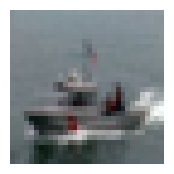


Image 1 (cat):


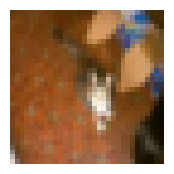


Image 2 (airplane):


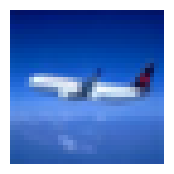

In [74]:
import matplotlib.pyplot as plt

# Define the class labels for CIFAR-10 dataset
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Loop to display the first three images in the batch along with their labels
for i in range(3):
    # Print the label of the current image
    print(f'\nImage {i} ({class_labels[int(y[i])]}):')
    # Convert the tensor image to a numpy array and reorder dimensions for matplotlib
    img = X[i].numpy().transpose(1, 2, 0)  # Reorder dimensions to height x width x channels.
    # Denormalize the image data to display correctly
    img = img * 0.5 + 0.5  # Undo normalization.
    plt.figure(figsize=(2,2))  # Create a figure with specified size
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Hide the axes ticks and labels
    plt.show()  # Show the plot with the image

### **2. Basic Architecture**

Once the DataLoaders for both the training and testing datasets are created, we would start with the basic architecture.

#### **Task**

In terms of the basic architecture, our first task is to implement the neural network architecture described in this section to classify images from
the CIFAR-10 dataset. The architecture is composed of a sequence of ***intermediate blocks B1, B2, . . . , BK*** that are followed by an ***output block O***.

**1. Implementing the Intermediate Block**
The intermediate block contains several convolutional layers that will process the input image independently. Their outputs will be merged into a single image using weights derived from the averages of the input's channels. These weights are calculated by averaging the input across channels and then feeding this through a fully connected layer that outputs a weight for each convolutional layer. This method dynamically adjusts each layer's influence on the final output, ensuring all convolutional outputs are effectively integrated regardless of their individual parameters.

In [87]:
import torch.nn as nn
import torch.nn.functional as F

# Define an Intermediate Block for the neural network
class IntermediateBlock(nn.Module):
    # Constructor with parameters for input and output channels, and the number of convolutional layers
    def __init__(self, in_channels, out_channels, num_conv_layers):
        # Call the constructor of the parent class (nn.Module)
        super(IntermediateBlock, self).__init__()
        self.in_channels = in_channels  # Store the number of input channels
        self.out_channels = out_channels  # Store the number of output channels
        self.num_conv_layers = num_conv_layers  # Store the number of convolutional layers in the block
        
        # Create a ModuleList to hold each convolutional layer; create 'num_conv_layers' convolutional layers
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_conv_layers)])
        
        # Fully connected layer to compute the attention scores, with one output per convolutional layer
        self.fc = nn.Linear(in_channels, num_conv_layers)

    # The forward method defines how the data flows through the block
    def forward(self, x):
        # Apply global average pooling to reduce each feature map to a single value (flattened to remove spatial dimensions)
        m = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        # Compute attention scores using a fully connected layer, followed by softmax for normalization
        a = torch.softmax(self.fc(m), dim=1)
        # Reshape attention scores to match the dimensions needed for element-wise multiplication with convolution outputs
        a = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        
        # List to store outputs of each convolutional layer
        conv_outputs = []
        for i in range(self.num_conv_layers):
            # Process the input through each convolutional layer independently
            conv_output = self.conv_layers[i](x)
            # Store the output of each convolutional layer, adding a new dimension to facilitate concatenation
            conv_outputs.append(conv_output.unsqueeze(1))
        
        # Stack all convolution outputs along a new dimension
        stacked_conv_outputs = torch.cat(conv_outputs, dim=1)
        # Multiply each convolution output by its corresponding attention score and sum across the stack to combine into a single output
        x_prime = (stacked_conv_outputs * a).sum(dim=1)
        
        # Return the combined output of the block
        return x_prime

#### **2. Output Block**


The output block will take the final image output from the last intermediate block, averaging its channels to form a vector ***m***. This vector will then pass through one or more fully connected layers to produce the classification logits vector ***o***, effectively transforming spatial channel information into final predictions.


In [88]:
# Defines an output block as a PyTorch module for neural networks
class OutputBlock(nn.Module):
    # Constructor with parameters for input channels and number of output classes
    def __init__(self, in_channels, num_classes):
        # Initialize the base class
        super(OutputBlock, self).__init__()
        # Define a global average pooling layer that reduces each feature map to a single value
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        # Define a fully connected layer to map from in_channels to num_classes
        self.fc = nn.Linear(in_channels, num_classes)

    # Forward method to define the computation performed at every call
    def forward(self, x):
        # Apply global average pooling to the input
        x = self.global_avg_pool(x)
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        # Pass the flattened output through the fully connected layer
        x = self.fc(x)
        # Return the final output
        return x

# Defines the whole neural network as a PyTorch module
class MyNet(nn.Module):
    # Constructor with parameters for initial channels, number of blocks, conv layers per block, and output classes
    def __init__(self, in_channels, num_blocks, num_conv_layers, num_classes):
        # Initialize the base class
        super(MyNet, self).__init__()
        # Sequentially stack intermediate blocks, adjusting in_channels for the first block
        self.blocks = nn.Sequential(
            # Generate a list of IntermediateBlock instances, with the first block receiving in_channels and the rest 64
            *[IntermediateBlock(in_channels if i == 0 else 64, 64, num_conv_layers) for i in range(num_blocks)]
        )
        # Define the output block with 64 input channels and the specified number of output classes
        self.output_block = OutputBlock(64, num_classes)

    # Forward method to define the computation performed at every call
    def forward(self, x):
        # Pass the input through all the intermediate blocks
        x = self.blocks(x)
        # Then pass the result through the output block
        x = self.output_block(x)
        # Return the final output
        return x

#### **3. Training and Testing**

For the training and testing stage, our objective is to train a neural network using the basic architecture outlined in the previous section. The network will receive batches of images with dimensions **b × 3 × 32 × 32**, where **b** represents the batch size, and output a **b × 10** matrix of logits. We will utilize a cross-entropy loss function during training. During training, the neural network iteratively optimizes its parameters using ***stochastic gradient descent (SGD)** with a learning rate of 0.01*. It computes the loss between predicted and actual labels for each batch of training data and updates the network parameters to minimize this loss. This process is repeated for a specified number of epoch (10 in our case)s. Following training, we will assess the network's performance by computing its accuracy on a separate testing dataset. The testing accuracy is calculated by comparing the predicted labels with the ground truth labels. This evaluation provides insights into the model's ability to generalize to unseen images"

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.1212074356969928, Training Accuracy: 21.304000000000002%, Test Accuracy: 24.45%
Epoch 2, Loss: 2.05985052617635, Training Accuracy: 23.23%, Test Accuracy: 24.64%
Epoch 3, Loss: 2.050555230178516, Training Accuracy: 23.778%, Test Accuracy: 25.2%
Epoch 4, Loss: 2.0427425036579847, Training Accuracy: 24.318%, Test Accuracy: 25.069999999999997%
Epoch 5, Loss: 2.030934391461041, Training Accuracy: 24.984%, Test Accuracy: 26.25%
Epoch 6, Loss: 2.015877290559135, Training Accuracy: 25.846000000000004%, Test Accuracy: 26.07%
Epoch 7, Loss: 2.0030715347327868, Training Accuracy: 26.488%, Test Accuracy: 27.62%
Epoch 8, Loss: 1.994205534191217, Training Accuracy: 27.211999999999996%, Test Accuracy: 27.900000000000002%
Epoch 9, Loss: 1.9866581577104554, Training Accuracy: 27.246%, Test Accuracy: 28.78%
Epoch 10, Loss: 1.9810956890432025, Training Accuracy: 27.582%, Test Accuracy: 28.46%


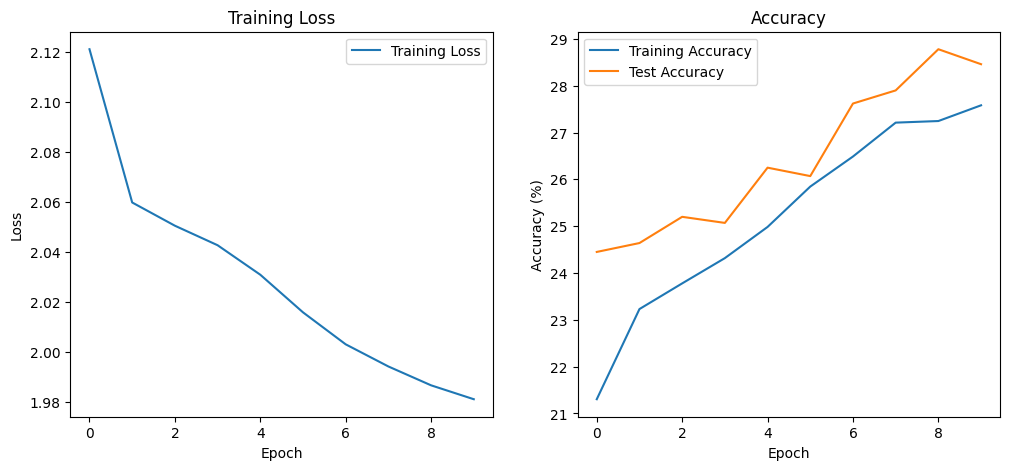

In [89]:
# Import the SGD optimizer from PyTorch's optim package
import torch.optim as optim
# Import transformation utilities from torchvision
import torchvision.transforms as transforms

# Function to train and validate the neural network model
def train_and_validate(net, train_loader, criterion, optimizer, scheduler, num_epochs=10):
    # Set the model to training mode
    net.train()
    # Lists to store training losses, training accuracies, and test accuracies
    train_losses, train_accuracies, test_accuracies = [], [], []
    
    # Iterate over the specified number of epochs
    for epoch in range(num_epochs):
        # Initialize variables to accumulate loss and accuracy metrics
        total_loss, total_correct, total_images = 0, 0, 0
        # Loop over batches in the training data loader
        for images, labels in train_loader:
            # Move images and labels to the active device (CPU/GPU)
            images, labels = images.to(device), labels.to(device)
            # Clear gradients before each backward pass
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = net(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()
            
            # Update total loss and correct predictions count
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
        
        # Calculate and store training loss and accuracy after each epoch
        train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_images * 100
        # Evaluate the model on the test set
        test_accuracy = test(net, test_loader)
        
        # Append metrics to their respective lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Update the learning rate scheduler
        scheduler.step(train_loss)
        # Print metrics for the current epoch
        print(f'Epoch {epoch+1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')
    
    # Plot training and validation metrics
    plot_metrics(train_losses, train_accuracies, test_accuracies)

# Function to evaluate the model on the test dataset
def test(net, test_loader):
    # Set the model to evaluation mode
    net.eval()
    total_correct, total_images = 0, 0
    # Disable gradient calculation to save memory and computations during inference
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
    accuracy = total_correct / total_images * 100
    return accuracy

# Function to plot training loss and accuracy over epochs
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Load data, initialize the model, loss function, optimizer, and start training
batch_size = 32
train_loader, test_loader = load_data_cifar10(batch_size)
net = MyNet(in_channels=3, num_blocks=1, num_conv_layers=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Execute the training and validation process
train_and_validate(net, train_loader, criterion, optimizer, scheduler, num_epochs=10)

#### **4. Improving the results**

From here onwards, the task would be to improve the results of the initial implementation. We would be training various neural networks on the training dataset to identify the architecture that yields the highest accuracy on the testing dataset. To enhance the results of our initial implementation, we will explore different hyperparameters and leverage techniques covered during Week 6 and Week 8 of the course. 

## **Intermediate Stage (Trial 1)**

This stage includes the exploration of new training techniques and different hyperparameters to enhance the results of the basic architecture model. We have introduced the following:

- Advanced Data Augmentation (Random Horizontal and Vertical Flips, Random Color Jitter, Random Rotation & Resized Crop)
- StepLR Scheduler
- Increased batch size (32 to 64)
- Increase in number of Epochs (10 to 20)
- Increase in number of intermediate blocks (1 to 6)

In [127]:
# Import necessary libraries
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Configure the device based on the availability of a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a function to load CIFAR-10 data with specified transformations and batch size
def load_data_cifar10(batch_size, resize=None):
    """Download the CIFAR-10 dataset and apply transformations including advanced data augmentation for training."""
    # Transformation pipeline for training data with data augmentation and normalization
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly alter color properties
        transforms.RandomRotation(15),  # Randomly rotate images within a 15-degree range
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Randomly crop and resize images
        transforms.ToTensor(),  # Convert PIL images to tensors
        transforms.Normalize(mean=[0.4914,0.4822,0.4465], std=[0.247,0.243,0.261]),  # Normalize the data
    ])
    # Transformation pipeline for test data (only normalization)
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]),
    ])
    # Load CIFAR-10 training data
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    # DataLoader for training data
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    # Load CIFAR-10 testing data
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    # DataLoader for testing data
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

In [128]:
# Set the batch size for data loading
batch_size = 64
# Load the CIFAR-10 dataset using the predefined function, receiving training and testing loaders
train_loader, test_loader = load_data_cifar10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [129]:
# Fetch the next batch of images (X) and labels (y) from the training loader
X, y = next(iter(train_loader))
# Print the dimensions of the batch of images, expecting a shape of [batch_size, channels, height, width]
print(X.size())  # Expected: [64, 3, 32, 32] for CIFAR-10 images (batch_size, channels, height, width)
# Print the dimensions of the batch of labels, expecting a shape that matches the batch size
print(y.size())  # Expected: [64] for CIFAR-10 labels (batch_size)

torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Image 0 (cat):


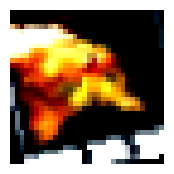

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Image 1 (cat):


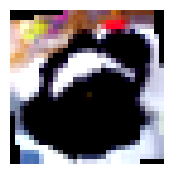

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Image 2 (frog):


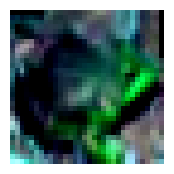

In [130]:
# Define the class labels for CIFAR-10 dataset
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Loop to display the first three images in the batch along with their labels
for i in range(3):
    # Print the label of the current image
    print(f'\nImage {i} ({class_labels[int(y[i])]}):')
    # Convert the tensor image to a numpy array and reorder dimensions for matplotlib
    img = X[i].numpy().transpose(1, 2, 0)  # Reorder dimensions to height x width x channels.
    # Denormalize the image data to display correctly
    img = img * 0.5 + 0.5  # Undo normalization.
    plt.figure(figsize=(2,2))  # Create a figure with specified size
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Hide the axes ticks and labels
    plt.show()  # Show the plot with the image

In [131]:
# Define an Intermediate Block for the neural network
class IntermediateBlock(nn.Module):
    # Constructor with parameters for input and output channels, and the number of convolutional layers
    def __init__(self, in_channels, out_channels, num_conv_layers):
        # Call the constructor of the parent class (nn.Module)
        super(IntermediateBlock, self).__init__()
        self.in_channels = in_channels  # Store the number of input channels
        self.out_channels = out_channels  # Store the number of output channels
        self.num_conv_layers = num_conv_layers  # Store the number of convolutional layers in the block
        
        # Create a ModuleList to hold each convolutional layer; create 'num_conv_layers' convolutional layers
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_conv_layers)])
        
        # Fully connected layer to compute the attention scores, with one output per convolutional layer
        self.fc = nn.Linear(in_channels, num_conv_layers)

    # The forward method defines how the data flows through the block
    def forward(self, x):
        # Apply global average pooling to reduce each feature map to a single value (flattened to remove spatial dimensions)
        m = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        # Compute attention scores using a fully connected layer, followed by softmax for normalization
        a = torch.softmax(self.fc(m), dim=1)
        # Reshape attention scores to match the dimensions needed for element-wise multiplication with convolution outputs
        a = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        
        # List to store outputs of each convolutional layer
        conv_outputs = []
        for i in range(self.num_conv_layers):
            # Process the input through each convolutional layer independently
            conv_output = self.conv_layers[i](x)
            # Store the output of each convolutional layer, adding a new dimension to facilitate concatenation
            conv_outputs.append(conv_output.unsqueeze(1))
        
        # Stack all convolution outputs along a new dimension
        stacked_conv_outputs = torch.cat(conv_outputs, dim=1)
        # Multiply each convolution output by its corresponding attention score and sum across the stack to combine into a single output
        x_prime = (stacked_conv_outputs * a).sum(dim=1)
        
        # Return the combined output of the block
        return x_prime

In [132]:
# Define a custom output block for the neural network
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        # Global average pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        # Fully connected layer for class prediction
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        # Apply global average pooling and flatten
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        # Output class scores
        x = self.fc(x)
        return x

# Define the overall network architecture
class MyNet(nn.Module):
    def __init__(self, in_channels, num_blocks, num_conv_layers, num_classes):
        super(MyNet, self).__init__()
        # Sequence of intermediate blocks
        self.blocks = nn.Sequential(
            *[IntermediateBlock(in_channels if i == 0 else 64, 64, num_conv_layers) for i in range(num_blocks)]
        )
        # Output block for final classification
        self.output_block = OutputBlock(64, num_classes)

    def forward(self, x):
        x = self.blocks(x)
        x = self.output_block(x)
        return x

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.275392461005989, Training Accuracy: 12.142%, Test Accuracy: 18.3%
Epoch 2, Loss: 2.1401431690091672, Training Accuracy: 18.94%, Test Accuracy: 20.9%
Epoch 3, Loss: 2.1188951692617763, Training Accuracy: 20.016000000000002%, Test Accuracy: 22.29%
Epoch 4, Loss: 2.1068197799765547, Training Accuracy: 20.698%, Test Accuracy: 22.43%
Epoch 5, Loss: 2.0973833808508675, Training Accuracy: 21.014%, Test Accuracy: 23.16%
Epoch 6, Loss: 2.094572824437905, Training Accuracy: 21.456%, Test Accuracy: 23.23%
Epoch 7, Loss: 2.0941575637558842, Training Accuracy: 21.256%, Test Accuracy: 23.91%
Epoch 8, Loss: 2.091933810345047, Training Accuracy: 21.418%, Test Accuracy: 23.849999999999998%
Epoch 9, Loss: 2.0895494329350073, Training Accuracy: 21.502%, Test Accuracy: 23.14%
Epoch 10, Loss: 2.0881809061750425, Training Accuracy: 21.42%, Test Accuracy: 23.91%
Epoch 11, Loss: 2.088959998791785, Training Accuracy: 2

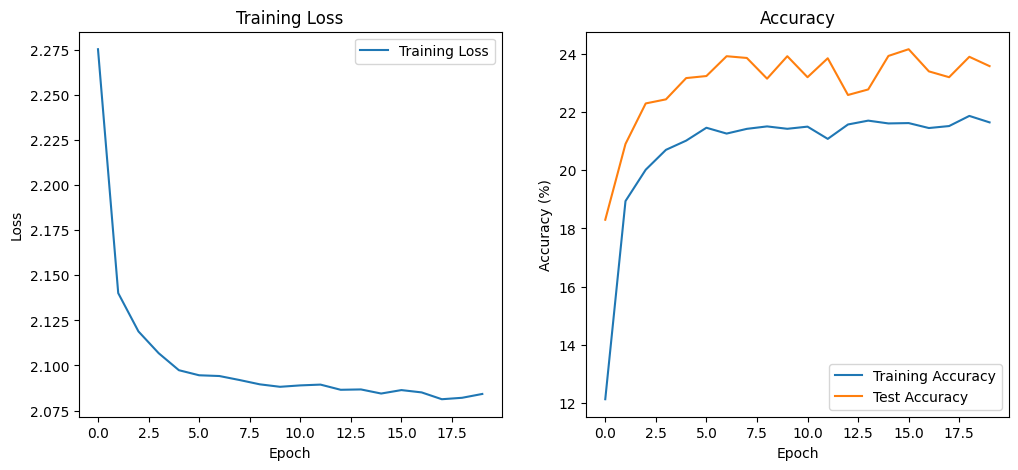

In [133]:
# Training and validation function
def train_and_validate(net, train_loader, criterion, optimizer, scheduler, num_epochs=20):
    net.train()
    # Initialize lists to store metrics
    train_losses, train_accuracies, test_accuracies = [], [], []
    
    for epoch in range(num_epochs):
        total_loss, total_correct, total_images = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
        
        # Calculate metrics for the current epoch
        train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_images * 100
        test_accuracy = test(net, test_loader)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        scheduler.step(train_loss)
        print(f'Epoch {epoch+1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')
    
    # Plot training and testing metrics
    plot_metrics(train_losses, train_accuracies, test_accuracies)

# Test function to evaluate the model on the test dataset
def test(net, test_loader):
    net.eval()
    total_correct, total_images = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
    # Calculate accuracy
    accuracy = total_correct / total_images * 100
    return accuracy

# Function to plot training loss and accuracy graphs
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Initialize and train the model
batch_size = 64
train_loader, test_loader = load_data_cifar10(batch_size)
net = MyNet(in_channels=3, num_blocks=6, num_conv_layers=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_and_validate(net, train_loader, criterion, optimizer, scheduler, num_epochs=20)

## **Advanced Stage (Final Trial)**

This stage includes the exploration of new training techniques and different hyperparameters to enhance the results of the intermediate stage (Trial 1) model. The following changes have been implemented:

- Advanced Data Augmentation to Normal Data Augmentation (removal of Random Color Jitter, Random Vertical Flip, & Random Rotation)
- Batch Normalization 
- Drop Out Regularization (value = 0.2)
- ReLU Activation Function
- Weight Decay Regularization (value = 1e-8)
- Increase in Intermediate Blocks & Epochs (Blocks from 6 to 12), (Epochs from 20 to 200)
- Decrease in Learning Rate (0.01 to 0.0005)
- Decrease in Batch Size (64 to 32)
- Optimizer changed from Stochastic Gradient Descent (SGD) to AdamW
- Scheduler changed from StepLR to CosineAnnealingLR

In [ ]:
# Importing necessary libraries and modules from PyTorch and torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

# Device configuration - using CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load and preprocess the CIFAR10 dataset
def load_data_cifar10(batch_size, resize=None):
    # Definition of preprocessing transformations for training data
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Randomly crop and resize images to 32x32 within scale limits
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]),  # Normalize tensor values
    ])
    # Definition of preprocessing transformations for testing data
    transform_test = transforms.Compose([
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]),  # Normalize tensor values
    ])
    # Loading the training dataset with specified transformations
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    # Creating a DataLoader for the training set with shuffling and multiprocessing
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    # Loading the testing dataset with specified transformations
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    # Creating a DataLoader for the test set without shuffling but with multiprocessing
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    # Returning both training and testing loaders
    return train_loader, test_loader

In [ ]:
# Define a class IntermediateBlock which inherits from nn.Module, used to create a neural network module
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        # Initialize the parent class (nn.Module)
        super(IntermediateBlock, self).__init__()
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.num_conv_layers = num_conv_layers  # Number of convolutional layers in the block
        
        # Create a list of convolutional layers, each followed by batch normalization and dropout
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_conv_layers)
        ])
        self.batch_norm_layers = nn.ModuleList([
            nn.BatchNorm2d(out_channels) for _ in range(num_conv_layers)
        ])
        self.dropout_layers = nn.ModuleList([
            nn.Dropout(0.2) for _ in range(num_conv_layers)
        ])
        
        # Fully connected layer to compute attention scores from global average pooled features
        self.fc = nn.Linear(in_channels, num_conv_layers)

    def forward(self, x):
        # Apply global average pooling to reduce spatial dimensions to 1x1 per channel
        m = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        # Compute attention scores using a fully connected layer followed by softmax for normalization
        a = torch.softmax(self.fc(m), dim=1)
        # Reshape attention scores to match the dimensions needed for multiplication with conv layer outputs
        a = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        
        # List to store the output of each convolutional layer
        conv_outputs = []
        for i in range(self.num_conv_layers):
            # Process input through i-th convolutional layer
            conv_output = self.conv_layers[i](x)
            # Apply batch normalization
            conv_output = self.batch_norm_layers[i](conv_output)
            # Apply ReLU activation function
            conv_output = F.relu(conv_output, inplace=True)
            # Apply dropout
            conv_output = self.dropout_layers[i](conv_output)
            # Store the output for later combination
            conv_outputs.append(conv_output.unsqueeze(1))
        
        # Concatenate all conv layer outputs along a new dimension
        stacked_conv_outputs = torch.cat(conv_outputs, dim=1)
        # Weight outputs by attention scores and sum across the new dimension
        x_prime = (stacked_conv_outputs * a).sum(dim=1)
        
        return x_prime  # Return the final output of the block

In [ ]:
# Define a class OutputBlock which inherits from nn.Module
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        # Initialize the parent class (nn.Module)
        super(OutputBlock, self).__init__()
        # Define an adaptive average pooling layer that reduces each channel to 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        # Define a fully connected (linear) layer that maps from in_channels to num_classes
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        # Apply global average pooling to the input feature map
        x = self.global_avg_pool(x)
        # Flatten the output from the global average pooling to fit the linear layer's input
        x = x.view(x.size(0), -1)
        # Apply the linear layer to produce the class scores
        x = self.fc(x)
        return x  # Return the output which includes class scores for each instance

# Define a class MyNet which inherits from nn.Module, representing the entire neural network
class MyNet(nn.Module):
    def __init__(self, in_channels, num_blocks, num_conv_layers, num_classes):
        # Initialize the parent class (nn.Module)
        super(MyNet, self).__init__()
        # Define a sequence of IntermediateBlock modules using nn.Sequential
        self.blocks = nn.Sequential(
            # Create a list of IntermediateBlock modules, the first block takes in_channels,
            # subsequent blocks use 64 output channels from the previous block
            *[IntermediateBlock(in_channels if i == 0 else 64, 64, num_conv_layers) for i in range(num_blocks)]
        )
        # Define the output block, which performs pooling and classification
        self.output_block = OutputBlock(64, num_classes)

    def forward(self, x):
        # Pass the input through the sequence of IntermediateBlocks
        x = self.blocks(x)
        # Pass the output of the blocks through the output block to get class scores
        x = self.output_block(x)
        return x  # Return the final output which includes class scores

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.6727703853974492, Training Accuracy: 36.164%, Test Accuracy: 47.13%
Epoch 2, Loss: 1.789469156445255, Training Accuracy: 30.04%, Test Accuracy: 42.34%
Epoch 3, Loss: 1.4850740051010214, Training Accuracy: 43.152%, Test Accuracy: 47.25%
Epoch 4, Loss: 1.326638106878797, Training Accuracy: 50.534%, Test Accuracy: 50.71%
Epoch 5, Loss: 1.2044081113617617, Training Accuracy: 55.972%, Test Accuracy: 53.87%
Epoch 6, Loss: 1.11356115345, Training Accuracy: 59.388%, Test Accuracy: 57.07%
Epoch 7, Loss: 1.0396778710896741, Training Accuracy: 62.212%, Test Accuracy: 64.77000000000001%
Epoch 8, Loss: 0.9819018773672601, Training Accuracy: 64.574%, Test Accuracy: 64.94%
Epoch 9, Loss: 0.932957661071803, Training Accuracy: 66.53%, Test Accuracy: 64.27000000000001%
Epoch 10, Loss: 0.8790283969633867, Training Accuracy: 68.36%, Test Accuracy: 68.73%
Epoch 11, Loss: 0.8355420127711232, Training Accuracy: 70.10

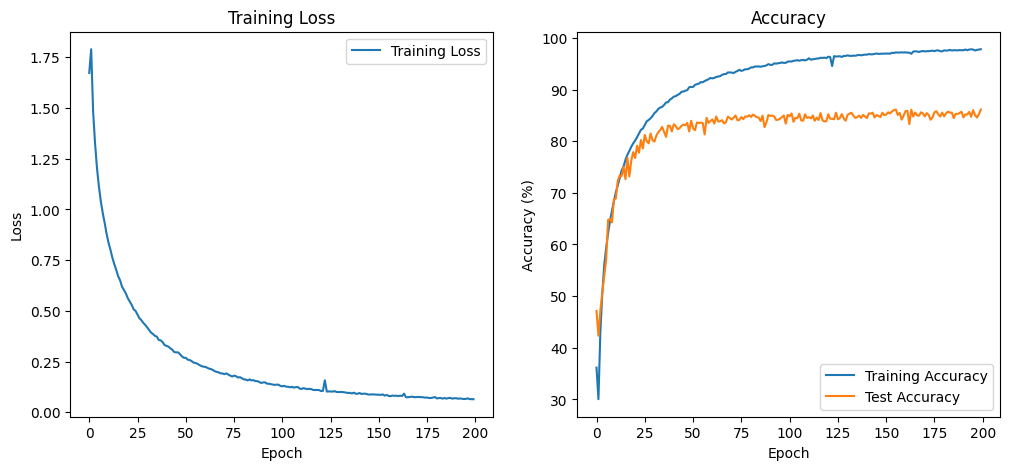

In [126]:
# Function to train and validate the neural network
def train_and_validate(net, train_loader, criterion, optimizer, scheduler, num_epochs=200):
    net.train()  # Set the network to training mode
    train_losses, train_accuracies, test_accuracies = [], [], []  # Lists to store metrics
    
    # Loop over the dataset multiple times
    for epoch in range(num_epochs):
        total_loss, total_correct, total_images = 0, 0, 0  # Initialize metrics for each epoch
        # Iterate over all batches in the train_loader
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = net(images)  # Forward pass: compute the output class probabilities
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass: compute the gradient of the loss w.r.t. parameters
            optimizer.step()  # Update the parameters using the optimizer
            
            total_loss += loss.item()  # Sum up the loss for reporting
            _, predicted = torch.max(outputs.data, 1)  # Get the predictions from the maximum value
            total_correct += (predicted == labels).sum().item()  # Count correct predictions
            total_images += labels.size(0)  # Count total predictions
        
        # Calculate average loss and accuracy over an epoch
        train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_images * 100
        test_accuracy = test(net, test_loader)  # Evaluate the network on the test data
        
        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Step the scheduler based on the training loss
        scheduler.step(train_loss)
        # Print progress
        print(f'Epoch {epoch+1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')
    
    # Plot training loss and accuracy trends
    plot_metrics(train_losses, train_accuracies, test_accuracies)

# Function to evaluate the network on the test dataset
def test(net, test_loader):
    net.eval()  # Set the network to evaluation mode
    total_correct, total_images = 0, 0
    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
    accuracy = total_correct / total_images * 100
    return accuracy

# Function to plot training and testing metrics
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))  # Set the figure size for the plots
    plt.subplot(1, 2, 1)  # Create subplot for training losses
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)  # Create subplot for accuracies
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()  # Display the plots

# Main script: setting up data loaders, network, loss function, optimizer, and scheduler
batch_size = 32
train_loader, test_loader = load_data_cifar10(batch_size)  # Load training and testing data
net = MyNet(in_channels=3, num_blocks=12, num_conv_layers=3, num_classes=10).to(device)  # Initialize the network
criterion = nn.CrossEntropyLoss()  # Setup the loss function
optimizer = optim.AdamW(net.parameters(), lr=0.0005, weight_decay=1e-8)  # Setup the optimizer with weight decay for regularization
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=0)  # Setup the learning rate scheduler

# Start the training and validation process
train_and_validate(net, train_loader, criterion, optimizer, scheduler, num_epochs=200)